In [1]:
import os
os.chdir('../')
# 导入 opencv-python
import cv2

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    """opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    """输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

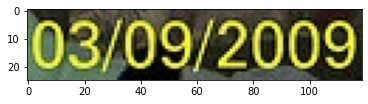

In [2]:
show_img_from_path('tests/data/ocr_toy_dataset/imgs/1036169.jpg')

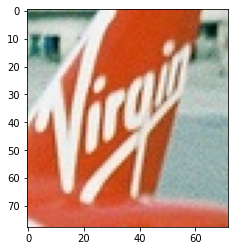

In [3]:
show_img_from_path('tests/data/ocr_toy_dataset/imgs/1058891.jpg')

In [4]:
from mmcv import Config
cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_stone_dataset.py')

In [5]:
from mmdet.apis import set_random_seed

# 存放输出结果和日志的目录
cfg.work_dir = './demo/tutorial_exps'

# 初始学习率 0.001 是针对 8 个 GPU 训练的
# 如果只有一个 GPU，则除以8
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None

# 每训练40张图像，记录一次日志
cfg.log_config.interval = 40

# 设置随机数种子
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [6]:
print(cfg.pretty_text)

checkpoint_config = dict(interval=1)
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='

In [7]:
import mmcv
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

In [8]:
# 建立数据集
datasets = [build_dataset(cfg.data.train)]

/home/featurize/work/mmocr/mmocr/datasets/utils/loader.py:86: UserWarning: HardDiskLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)


In [9]:
# 建立模型
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# 创建新目录，保存训练结果
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [10]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/featurize/work/mmocr/mmocr/apis/train.py:86: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  'please set `runner` in your config.', UserWarning)
/home/featurize/work/mmocr/mmocr/apis/utils.py:53: UserWarning: Remove "MultiRotateAugOCR" to support batch inference since samples_per_gpu > 1.
  warnings.warn(warning_msg)
/home/featurize/work/mmocr/mmocr/datasets/utils/loader.py:86: UserWarning: HardDiskLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)
2022-04-19 13:41:57,812 - mmocr - INFO - Start running, host: featurize@featurize, work_dir: /home/featurize/work/mmocr/demo/tutorial_exps
2022-04-19 13:41:57,813 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                    

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 9/9, 30.6 task/s, elapsed: 0s, ETA:     0s

2022-04-19 13:42:17,575 - mmocr - INFO - 
Evaluateing tests/data/ocr_stone_dataset/label.txt with 9 images now
2022-04-19 13:42:17,583 - mmocr - INFO - Epoch(val) [1][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-04-19 13:42:22,362 - mmocr - INFO - Epoch [2][40/225]	lr: 1.250e-04, eta: 0:01:05, time: 0.119, data_time: 0.054, memory: 1783, loss_ce: 0.2397, loss: 0.2397
2022-04-19 13:42:24,997 - mmocr - INFO - Epoch [2][80/225]	lr: 1.250e-04, eta: 0:01:01, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2287, loss: 0.2287
2022-04-19 13:42:27,607 - mmocr - INFO - Epoch [2][120/225]	lr: 1.250e-04, eta: 0:00:57, time: 0.065, data_time: 0.002, memory: 1783, loss_ce: 0.1878, loss: 0.1878
2022-04-19 13:42:30,213 - mmocr - INFO - Epoch [2][160/225]	lr: 1.250e-04, eta: 0:00:54, time: 0.065, data_time: 0.002, memory: 1783, loss_ce: 0.2224, loss: 0.2224
2022-04-19 13:42:3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 9/9, 32.3 task/s, elapsed: 0s, ETA:     0s

2022-04-19 13:42:37,090 - mmocr - INFO - 
Evaluateing tests/data/ocr_stone_dataset/label.txt with 9 images now
2022-04-19 13:42:37,093 - mmocr - INFO - Epoch(val) [2][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-04-19 13:42:41,841 - mmocr - INFO - Epoch [3][40/225]	lr: 1.250e-04, eta: 0:00:46, time: 0.118, data_time: 0.054, memory: 1783, loss_ce: 0.2457, loss: 0.2457
2022-04-19 13:42:44,463 - mmocr - INFO - Epoch [3][80/225]	lr: 1.250e-04, eta: 0:00:42, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2583, loss: 0.2583
2022-04-19 13:42:47,090 - mmocr - INFO - Epoch [3][120/225]	lr: 1.250e-04, eta: 0:00:39, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2256, loss: 0.2256
2022-04-19 13:42:49,733 - mmocr - INFO - Epoch [3][160/225]	lr: 1.250e-04, eta: 0:00:36, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2206, loss: 0.2206
2022-04-19 13:42:5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 9/9, 30.4 task/s, elapsed: 0s, ETA:     0s

2022-04-19 13:42:56,923 - mmocr - INFO - 
Evaluateing tests/data/ocr_stone_dataset/label.txt with 9 images now
2022-04-19 13:42:56,926 - mmocr - INFO - Epoch(val) [3][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-04-19 13:43:01,708 - mmocr - INFO - Epoch [4][40/225]	lr: 1.250e-05, eta: 0:00:29, time: 0.119, data_time: 0.055, memory: 1783, loss_ce: 0.2420, loss: 0.2420
2022-04-19 13:43:04,330 - mmocr - INFO - Epoch [4][80/225]	lr: 1.250e-05, eta: 0:00:26, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.1712, loss: 0.1712
2022-04-19 13:43:06,955 - mmocr - INFO - Epoch [4][120/225]	lr: 1.250e-05, eta: 0:00:23, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2124, loss: 0.2124
2022-04-19 13:43:09,595 - mmocr - INFO - Epoch [4][160/225]	lr: 1.250e-05, eta: 0:00:20, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2466, loss: 0.2466
2022-04-19 13:43:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 9/9, 31.1 task/s, elapsed: 0s, ETA:     0s

2022-04-19 13:43:16,458 - mmocr - INFO - 
Evaluateing tests/data/ocr_stone_dataset/label.txt with 9 images now
2022-04-19 13:43:16,460 - mmocr - INFO - Epoch(val) [4][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-04-19 13:43:21,214 - mmocr - INFO - Epoch [5][40/225]	lr: 1.250e-06, eta: 0:00:13, time: 0.118, data_time: 0.054, memory: 1783, loss_ce: 0.2302, loss: 0.2302
2022-04-19 13:43:23,836 - mmocr - INFO - Epoch [5][80/225]	lr: 1.250e-06, eta: 0:00:10, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2501, loss: 0.2501
2022-04-19 13:43:26,469 - mmocr - INFO - Epoch [5][120/225]	lr: 1.250e-06, eta: 0:00:07, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2332, loss: 0.2332
2022-04-19 13:43:29,097 - mmocr - INFO - Epoch [5][160/225]	lr: 1.250e-06, eta: 0:00:04, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2394, loss: 0.2394
2022-04-19 13:43:3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 9/9, 30.5 task/s, elapsed: 0s, ETA:     0s

2022-04-19 13:43:35,998 - mmocr - INFO - 
Evaluateing tests/data/ocr_stone_dataset/label.txt with 9 images now
2022-04-19 13:43:36,000 - mmocr - INFO - Epoch(val) [5][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000


In [11]:
from mmocr.apis import init_detector, model_inference
# 指定模型 checkpoint 权重文件
checkpoint = "./demo/tutorial_exps/epoch_5.pth"


model = init_detector(cfg, checkpoint, device="cuda:0")

load checkpoint from local path: ./demo/tutorial_exps/epoch_5.pth


/home/featurize/work/mmocr/mmocr/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


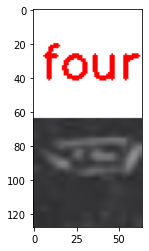

In [15]:
# 指定待测图像路径
input_path = 'tests/data/ocr_stone_dataset/imgs/000012.jpg'
result = model_inference(model, input_path)
result
out_img = model.show_result(input_path, result, out_file='outputs/demo-out.jpg', show=False)
show_img_from_array(out_img)